# Predicting interest rates from Federal Reserve documents
## Model Training (Vol. 6)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

## Environment

In [44]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [45]:
# Use TPU
if IN_COLAB:
  # TPU Setting
  import os
  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
  VERSION = "20200220"
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  22438      0 --:--:-- --:--:-- --:--:-- 22438
Traceback (most recent call last):
  File "pytorch-xla-env-setup.py", line 161, in <module>
    run_setup(args)
  File "pytorch-xla-env-setup.py", line 123, in run_setup
    version = get_version(args.version)
  File "pytorch-xla-env-setup.py", line 76, in get_version
    raise ValueError(f'Oldest nightly version available is {OLDEST_VERSION}')
ValueError: Oldest nightly version available is 2020-03-18 00:00:00


In [46]:
#if IN_COLAB:
  # Uninstall existing versions:
  #!pip uninstall numpy -y
  #!pip uninstall pandas -y
  #!pip uninstall tqdm -y
  #!pip uninstall torch -y
  #!pip uninstall scikit-plot -y
  #!pip uninstall transformers -y
  
  # Install packages:
  #!pip install numpy==1.16.4
  #!pip install pandas
  #!pip install torch==1.4.0
  #!pip install tqdm==4.43.0
  #!pip install scikit-plot
  #!pip install transformers
  #os.kill(os.getpid(), 9)

In [47]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [49]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [50]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [51]:
# Check Device
#if IN_COLAB:
#  torch.cuda.get_device_name(0)

## Load preprocessed data

In [52]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [54]:
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()
#train_df = pd.read_csv(train_dir + 'nontext_train_small.csv')
#print(train_df.shape)
train_df


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426


In [55]:
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [56]:
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()
#text_no_split = pd.read_csv(preprocessed_dir + 'text_no_split.csv')
print(text_no_split['next_decision'])
file = open(preprocessed_dir + 'text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()
#text_split_200 = pd.read_csv(preprocessed_dir + 'text_split_200.csv')
#text_split_200.head(10)
file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()
#text_keyword = pd.read_csv(preprocessed_dir + 'text_keyword.csv')
#text_keyword.head(10)

0        <NA>
1        <NA>
2        <NA>
3        <NA>
4        <NA>
         ... 
48578    <NA>
48579    <NA>
48580    <NA>
48581    <NA>
48582    <NA>
Name: next_decision, Length: 48583, dtype: object


## Check the statistics of texts

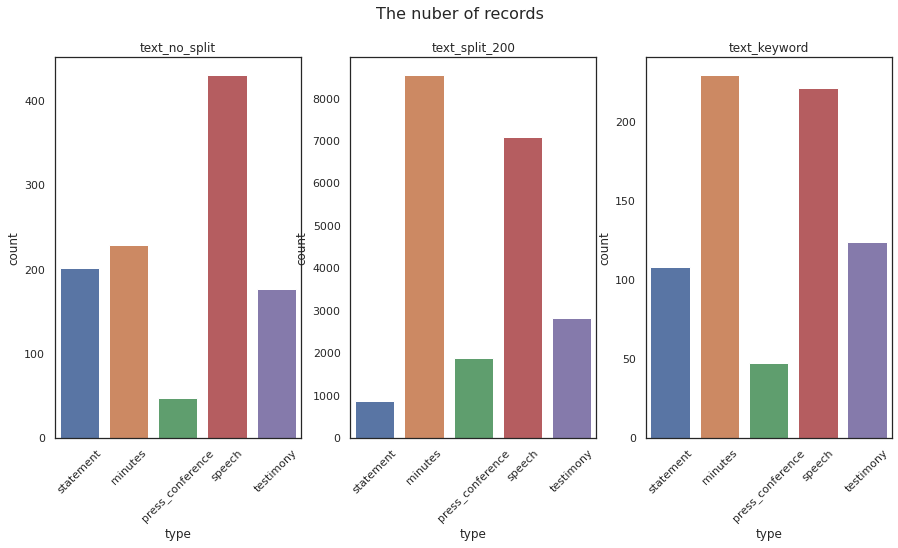

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

In [58]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,index


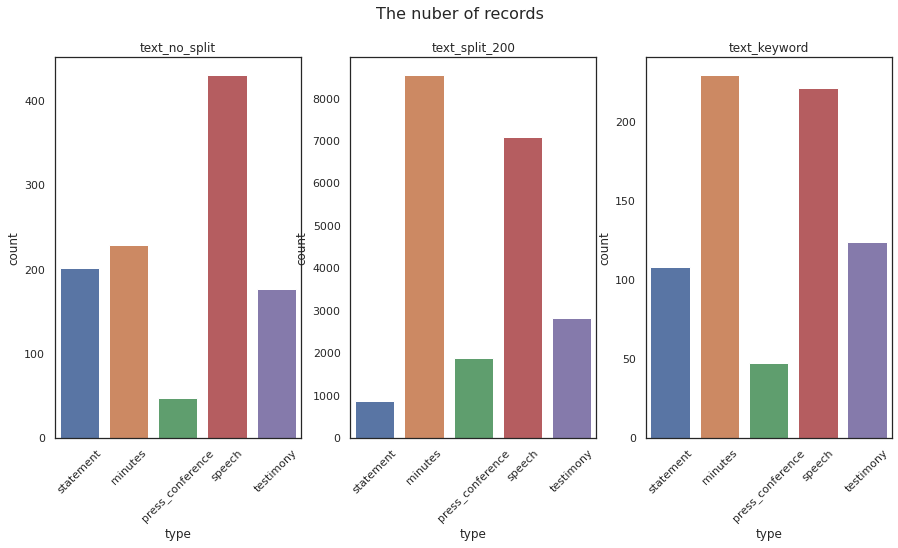

In [59]:
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

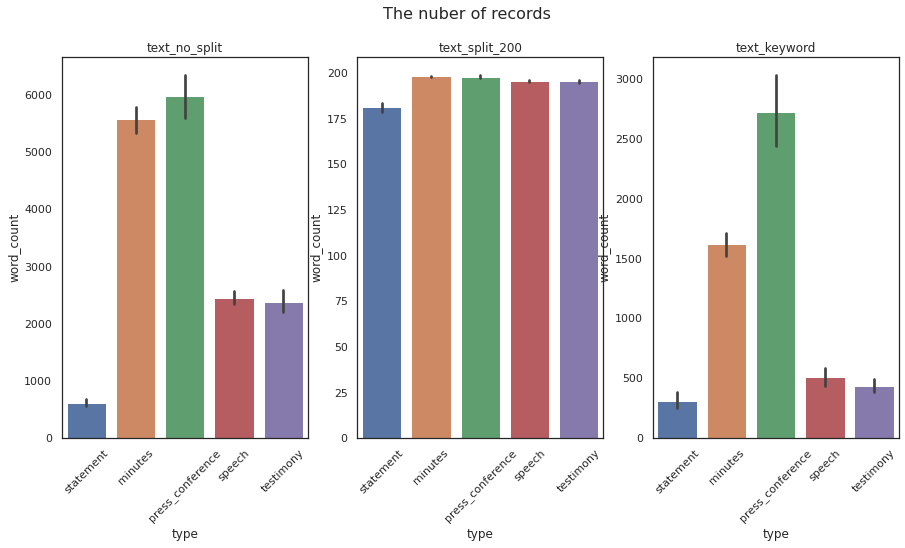

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.barplot(data=text_no_split, x='type', y='word_count', ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

### Select text dataframe

In [61]:
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(48583, 12)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,index
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,<NA>,None,1994-07-06,<NA>,None,"In taking the discount action, the Board appro...",NaN
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,<NA>,None,1994-09-27,<NA>,None,"In taking the discount rate action, the Board ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48578,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1171,<NA>,None,2020-03-03,<NA>,None,My colleagues and I strongly support the goals...,NaN
48579,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,<NA>,None,I would like to begin by acknowledging the tra...,NaN
48580,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1433,<NA>,None,2020-07-29,<NA>,None,Our country continues to face a difficult and ...,NaN
48581,testimony,2020-06-30,Coronavirus and CARES Act,Jerome Powell,2759,<NA>,None,2020-07-29,<NA>,None,We meet as the pandemic continues to cause tre...,NaN


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


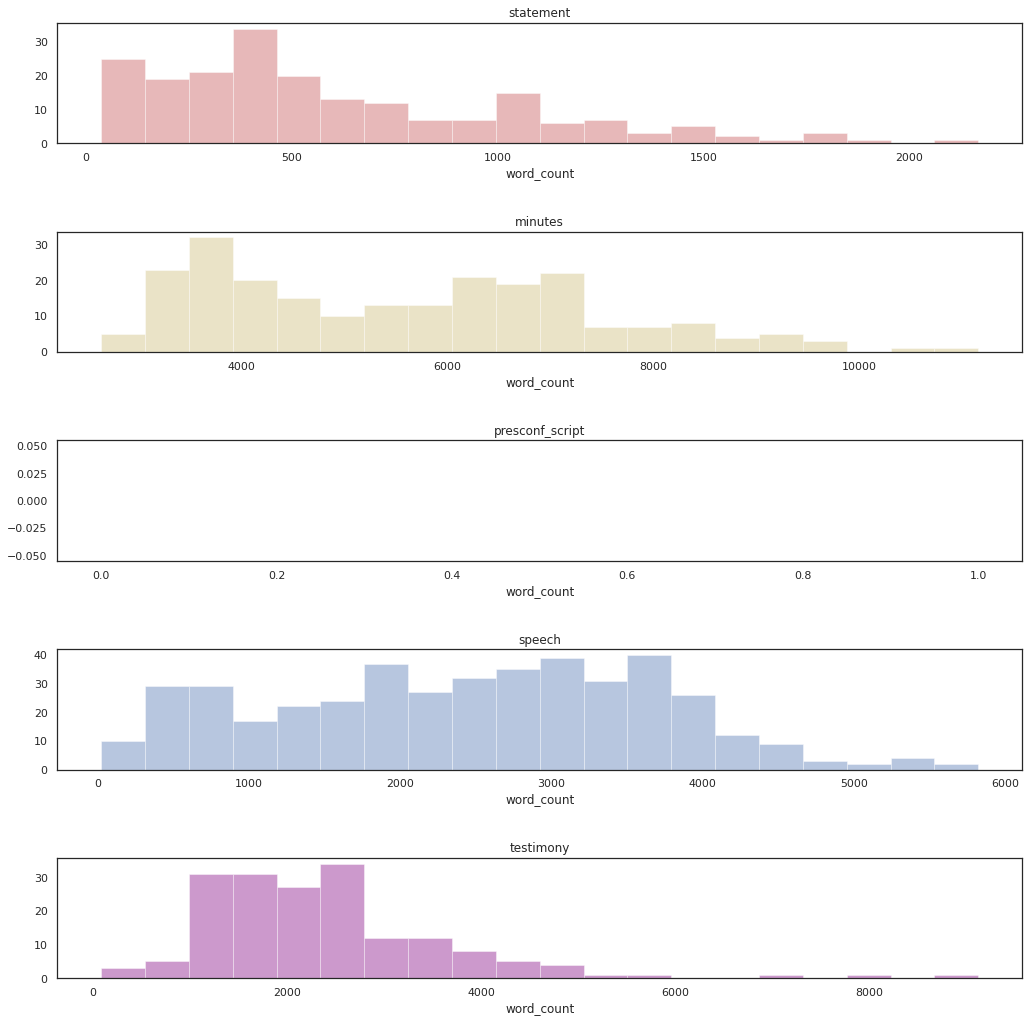

In [62]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

In [63]:
# Check balance of Rate Decision
#g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
#g.map(sns.countplot, 'next_decision')
#plt.show()

## Merge text to the train dataframe

In [64]:
from collections import defaultdict 

doc_types = text_df['type'].unique()
merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)

In [65]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,press_conference,NaN,speech,testimony,text
date,,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,,
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,,,,
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,,,,
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,,,,
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279,The fundamentals of the U.S. economy remain s...,,Earlier today the Federal Open Market Committ...,,,,The fundamentals of the U.S. economy remain s...
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,The coronavirus outbreak has harmed communiti...,Developments in Financial Markets and Open Ma...,"Good evening, everyone. Today the Federal Res...",,,,The coronavirus outbreak has harmed communiti...
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426,,,,,,,


In [66]:
count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

123977 words in original text for statement
121762 words in merged text for statement
1270696 words in original text for minutes
1238045 words in merged text for minutes
266192 words in original text for press_conference
235895 words in merged text for press_conference
0 words in original text for nan
0 words in merged text for nan
1044550 words in original text for speech
1037401 words in merged text for speech
418890 words in original text for testimony
410549 words in merged text for testimony
Total: 3124305 words in original text
Total: 3043652 words in merged text
Total: 3043652 words in text column of merged text


Looks okay, but there are may rows without text as texts are only available from certain year.
It's not easy to fill those null values - for now drop those though the number of training data gets small...

In [67]:
print("Before dropping: ", train_df.shape)
train_df = train_df.loc[train_df['text'] != ""]
print("After dropping: ", train_df.shape)

Before dropping:  (398, 17)
After dropping:  (244, 17)


## Explore the text

In [68]:
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [69]:
corpus = create_corpus(text_df)

In [70]:
x, y = get_frequent_stop_words(corpus)

In [71]:
print(x)
print(y)

('the', 'of', 'to', 'in', 'and', 'that', 'a', 'we', 'i', 'is')
(760075, 384452, 380839, 321089, 273148, 269124, 230617, 151883, 149907, 148575)


In [72]:
x, y = get_frequent_nonstop_words(corpus)

In [73]:
print(x)
print(y)

('would', 'think', 'inflation', 'rate', 'growth', 'policy', 'market', 'going', 'percent', 'one')
(64634, 53583, 35990, 35196, 28890, 27824, 27640, 25397, 23984, 23320)


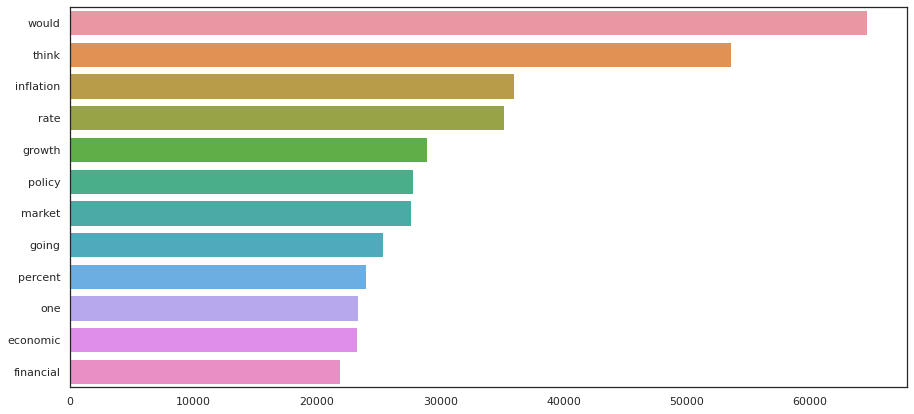

In [74]:
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

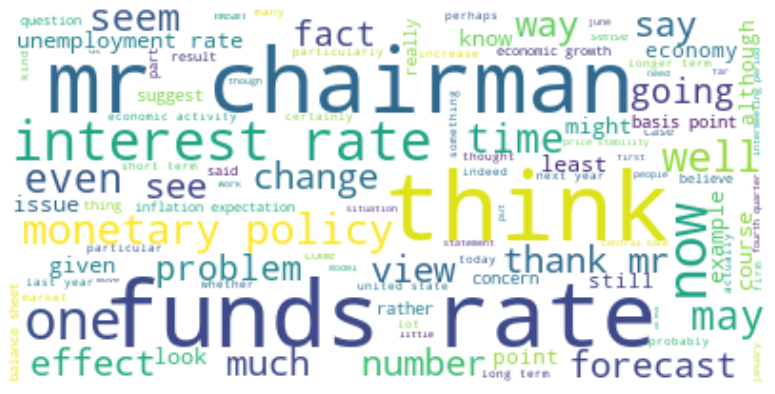

In [75]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])
text = " ".join(corpus)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Source: https://sraf.nd.edu/textual-analysis/resources/.

In [76]:
sentiment_df = pd.read_csv(keyword_lm_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')
print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
...,...,...
4135,Constraining,STRICTER
4136,Constraining,STRICTEST
4137,Constraining,STRICTLY
4138,Constraining,UNAVAILABILITY


In [77]:
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [78]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [79]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [80]:
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df


(48583, 12)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,index,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,Chairman Alan Greenspan announced today that t...,NaN,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,<NA>,None,1994-07-06,<NA>,None,"In taking the discount action, the Board appro...",NaN,0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,<NA>,None,1994-09-27,<NA>,None,"In taking the discount rate action, the Board ...",NaN,0.000000,51,0,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48578,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1171,<NA>,None,2020-03-03,<NA>,None,My colleagues and I strongly support the goals...,NaN,0.170794,1171,25,23,"[stability, strengthened, stable, gains, gains...","[force, unemployment, unemployment, weak, slug..."
48579,testimony,2020-05-19,Coronavirus and CARES Act,Jerome Powell,1802,<NA>,None,2020-06-10,<NA>,None,I would like to begin by acknowledging the tra...,NaN,-0.665927,1802,33,45,"[tremendous, greatly, able, gains, great, trem...","[tragic, loss, hardship, crisis, closed, curta..."
48580,testimony,2020-06-16,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1433,<NA>,None,2020-07-29,<NA>,None,Our country continues to face a difficult and ...,NaN,-0.907188,1433,30,43,"[tremendous, positive, able, greater, progress...","[difficult, challenging, hardship, crisis, une..."
48581,testimony,2020-06-30,Coronavirus and CARES Act,Jerome Powell,2759,<NA>,None,2020-07-29,<NA>,None,We meet as the pandemic continues to cause tre...,NaN,-0.108735,2759,46,49,"[tremendous, tremendous, greater, rebounded, p...","[hardship, crisis, decline, losses, decline, s..."


In [81]:
tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=str(doc_type))]
    tone_lmdict_list.append(tone_lmdict)

train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df = [x for x in train_df if x != 'nan']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
train_df

['target',
 'prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff',
 'statement',
 'minutes',
 'press_conference',
 nan,
 'speech',
 'testimony',
 'text',
 'tone']

TypeError: ignored

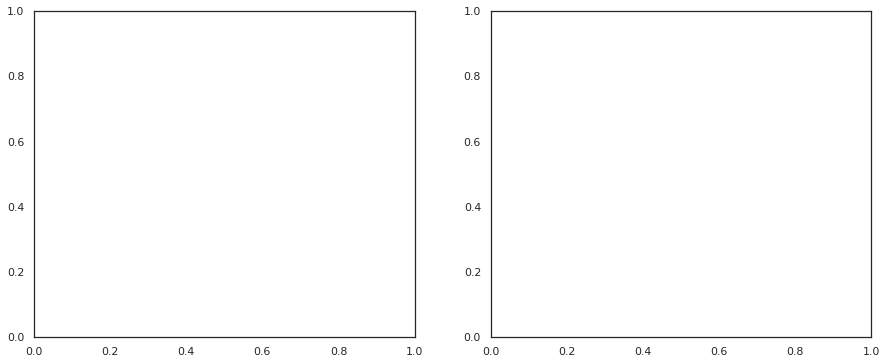

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
corr_columns = ['target', 'tone', 'prev_decision']
sns.heatmap(train_df['target', 'tone', 'prev_decision'].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")
corr_columns = ['next_decision', 'tone_score', 'decision']
sns.heatmap(text_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation of text_df")
plt.show()

In [ ]:
corr_columns = ['next_decision', 'tone_score', 'type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
df = text_df[corr_columns]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(df.loc[df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

# Tokenize and vectorize

In [ ]:
def lemmatize_word(word):
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized

## Tokenize text_df

In [ ]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])

In [ ]:
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

In [ ]:
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}
print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

In [ ]:
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

In [ ]:
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

In [ ]:
freq = {}
num_words = len(all_words)
print('len(all_words): ', len(all_words))
for key in counts:
  freq[key] = counts[key]/num_words

  print('len(freq): ', len(freq))
  print(freq['rate'])

  low_cutoff = 0.000001
  high_cutoff = 20

  K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

  filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
  print(K_most_common)
  print('len(filtered_words): ', len(filtered_words))

## Tokenize train_df

In [ ]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

counts = Counter(all_words)
print('len(counts): ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))

In [ ]:
sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))

In [ ]:
len(token_ids[0])

## Lemmatize sentiment

In [ ]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [ ]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

## Tfidf 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
  vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
  tfidf = vectorizer.fit_transform(docs)
  features = vectorizer.get_feature_names()
  return tfidf.toarray()

### Text dataframe

In [ ]:
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

In [ ]:
text_df.shape

In [ ]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
text_df

### Train dataframe

In [ ]:
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}
print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))
for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
train_df

## Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(tfidf_matrix):
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [ ]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

In [ ]:
for sentiment in lemma_sentiments:
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
train_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

### Convert target class for classification

In [ ]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [ ]:
train_df['target'] = train_df['target'].map(convert_class)

In [ ]:
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

# Modeling and Training
## Common Functions

In [ ]:
kfold = StratifiedKFold(n_splits=3)
kfold

In [ ]:
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])
        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)
        X_axis = np.array(results['param_' + x_param].data, dtype=float)
        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))
        ax2.legend(loc="best")
        ax2.grid(False)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")      
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


## A. Cosin Similarity
### Train and Test Data

In [ ]:
train_df.columns

In [ ]:
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']]

X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

In [ ]:
rf_clf = RandomForestClassifier()
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")

## B. Tfidf

In [ ]:
train_df

In [ ]:
vocabulary=sentiment_dict['Negative']+sentiment_dict['Positive']

In [ ]:
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'tokenized_text']]
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
import scipy
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

from sklearn.preprocessing import FunctionTransformer
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

clf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', vocabulary=vocabulary))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

param_grid = {'clf__n_estimators': np.linspace(1, 60, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}
rf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [ ]:
y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'token_ids']]

X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

### Model
#### Embed -> RNN -> Dense -> Softmax

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        dense_out = self.fc1(lstm_out)
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)
        return logps, hidden_state

### DataLoaders and Batching

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [ ]:
def dataloader(messages, meta, labels, sequence_length=200, batch_size=16, shuffle=False):
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        meta = [meta[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
        
        yield batch, meta_tensor, label_tensor

In [ ]:
text_batch, meta_batch, labels = next(iter(dataloader(X_train_text, X_train_meta, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, meta_size, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, meta_batch, hidden)
print(logps)

### Configure the model and train!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

In [ ]:
def train_model(model, epochs=3, batch_size=8, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, meta_batch, labels in dataloader(
                X_train_text, X_train_meta, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            if text_batch.size(1) != batch_size:
                break

            hidden = tuple([each.data for each in hidden])
        
            text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            output, hidden = model(text_batch, meta_batch, hidden)

            loss = criterion(output, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, meta_batch, labels in dataloader(
                        X_valid_text, X_valid_meta, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    if text_batch.size(1) != batch_size:
                        break

                    # valid_hidden = model.init_hidden(labels.shape[0])
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    valid_output, valid_hidden = model(text_batch, meta_batch, valid_hidden)

                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Lower', 'Hold', 'Raise']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

In [ ]:
train_model(model)

## D. Glove Word Embedding + LSTM

In [ ]:
glove_file = 'glove.6B.300d.pickle'
glove_path = glove_dir + glove_file
embedding_dict = {}
with open("/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], 'float32')
    embedding_dict[word] = vectors
f.close()
pickle.dump(embedding_dict, open(glove_path, 'wb'))

In [ ]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']

In [ ]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

In [ ]:
type(weight_matrix)

In [ ]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        dense_out = self.fc1(lstm_out)
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure/Train Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

In [ ]:
train_model(model)

In [ ]:
train_df.columns

In [ ]:
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'presconf_script', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'])

In [ ]:
split_train_df.shape

In [ ]:
def get_split(text, split_len=200, overlap=50):
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            #row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)

    return split_df

In [ ]:
split_train_df = get_split_df(split_train_df)
split_train_df.shape

In [ ]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
split_train_df['token_ids'] = token_ids


In [ ]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))
        

In [ ]:
split_train_df.head()

In [ ]:
sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))

In [ ]:
y_data = split_train_df['target']
X_data = split_train_df[nontext_columns + ['tone', 'token_ids']]

X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

In [ ]:
len(weight_matrix)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

In [ ]:
train_model(model, epochs=3, batch_size=16, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10)

## E. BERT Model

In [ ]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch


In [ ]:
class InputFeature(object):
    def __init__(self, id, input_ids, masks, segments, meta, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments,
            'meta': meta
        }
        self.label = label

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=200):
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [ ]:
train_set = []
max_seq_length = 200
meta_size = 10

for index, row in tqdm(split_train_df.iterrows(), total=split_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['text'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row[nontext_columns + ['tone']], int(row['target'])))    

train_labels = split_train_df['target'].astype(int).values

train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_meta =np.array([data.features['meta'] for data in train_set], dtype=np.float64)
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(split_train_df), 3), dtype=np.float32)

In [ ]:
print(train_valid_meta[0])
print(train_valid_meta[1])

In [ ]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, meta_size, output_size, dropout=0.1):
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, nn_input_meta):     
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        dense_out = self.fc1(self.dropout(feature))
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        # print(len(dense_out[0]))
        # print(len(nn_input_meta[0]))
        # print(len(concat_layer[0]))
        # print("dense_out: \n", dense_out)
        # print("nn_input_meta: \n", nn_input_meta)
        # print("concat_layer: \n", concat_layer)
        out = self.fc2(concat_layer)
        #logps = self.softmax(out)

        return out

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs)


In [ ]:
bert_model = BertTextClassifier(768, 128, meta_size, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids, x_meta)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

In [ ]:
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size =128

In [ ]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    train_meta = torch.tensor(train_valid_meta[train_indices], dtype=torch.long)
    
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)
    valid_meta = torch.tensor(train_valid_meta[valid_indices], dtype=torch.long)

    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_meta, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_meta, valid_label)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, meta_size, 3, dropout=0.1)
    
    device = 'cuda:0' if torch.cuda.is_available() else 'tpu'
    bert_model = bert_model.to(device)
    
    loss_fn = torch.nn.CrossEntropyLoss()

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    bert_model.train()

    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            
            y_pred = bert_model(x_ids, x_meta)

            loss = loss_fn(y_pred, y_truth)
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() / len(train_loader)
            
            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        model.eval()
        
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, x_meta, y_truth = batch
                y_pred = bert_model(x_ids, x_meta).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        if early_stop >= patience:
            break
            
        model.train()

    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    bert_model.eval()
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            y_pred = bert_model(x_ids, x_meta).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()

    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

In [ ]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


In [ ]:
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

# Save Data

In [ ]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=preprocessed_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=preprocessed_dir):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

In [ ]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')